In [1]:
from matplotlib import pyplot as plt
import os
from scipy.io.wavfile import read
import scipy
import numpy as np
import random
import torch
import librosa
from librosa.feature import melspectrogram
import scaleogram as scg 
from logmmse import logmmse_from_file
import pywt
import seaborn as sns
import pandas as pd
import sys
import cv2
from AEspeech import AEspeech
import pdb
# from phonetGM2 import Phonet

C:\Users\Gabriel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
C:\Users\Gabriel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Gabriel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Gabriel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [2]:
from SpecDatset import SpecDataset
import time
import torch
import numpy as np
import pandas as pd
import numpy.fft
import os
import sys
from CAE import CAEn
from scipy.signal import butter, lfilter

PATH=os.getcwd()
sys.path.append(PATH+"/toolbox/")
import traintestsplit as tts

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
def compute_spectrograms(wav_file,nb,NMELS):
        """
        Compute the tensor of Mel-scale spectrograms to be used as input for the autoencoders from a wav file
        :param wav_file: *.wav file with a sampling frequency of 16kHz
        :returns: Pytorch tensor (N, C, F, T). N: batch of spectrograms extracted every 500ms, C: number of channels (1),  F: number of Mel frequencies (128), T: time steps (126)
        """        
        FS=16000
        fs_in, signal=read(wav_file)
        sig_len=len(signal)
        
        FRAME_SIZE=(FS*.5)/sig_len
        TIME_SHIFT=FRAME_SIZE/2
        TIME_STEPS=126
        
        #binary narrowband: 1 yes, 0 no (i.e. broadband)
        if nb==0:
            #broadband: higher time resolution, less frequency resolution
            HOP=int(FS*.003)#3ms hop (48 SAMPLES)
            WIN_LEN=int(FS*.005)#5ms time window (60 SAMPLES)
            signal=butter_bandpass_filter(signal,50,7000,FS)
        elif nb==1:
            #narrowband: higher frequency resolution, less time resolution
            HOP=int(FS*.01) #10ms hop (160 SAMPLES)
            WIN_LEN=int(FS*.03) #30ms time window (480 SAMPLES)
            signal=butter_bandpass_filter(signal,300,5400,FS)
        
        if fs_in!=FS:
            raise ValueError(str(fs)+" is not a valid sampling frequency")
            
        signal=signal-np.mean(signal)
        signal=signal/np.max(np.abs(signal))
        init=0
        endi=int(FRAME_SIZE*sig_len)
        nf=int(1/TIME_SHIFT)-1
        
        if nf>0:
            mat=torch.zeros(nf,1,128,TIME_STEPS)
            j=0
            for k in range(nf):
                frame=signal[init:endi]
                imag=melspectrogram(frame, sr=16000, n_fft=1024,win_length=WIN_LEN, hop_length=HOP, n_mels=NMELS, fmax=FS//2)
                imag=imag[np.where(imag[:,0]>0)]
                imag=cv2.resize(imag,(126,128),interpolation=cv2.INTER_CUBIC)
                imag=np.abs(imag)
#                 pdb.set_trace()
                #                 imag=(imag-np.min(imag))/(np.max(imag)-np.min(imag))
                
                init=init+int(TIME_SHIFT*sig_len)
                endi=endi+int(TIME_SHIFT*sig_len)
                if np.min(np.min(imag))<=0:
                    warnings.warns("There is Inf values in the Mel spectrogram")
                    continue
                imag=np.log(imag, dtype=np.float32)
                imagt=torch.from_numpy(imag)
                mat[j,:,:,:]=imagt
                j+=1
                
#         return torch.reshape(imagt,(1,1,imagt.size()[0],imagt.size()[1])),len(signal)
        return mat,len(signal)

In [5]:
def show_spectrograms(spectrograms1,sig_len,title,nb,spectrograms2=None):
    """
    Visualization of the computed tensor of Mel-scale spectrograms to be used as input for the autoencoders from a wav file
    :param spectrograms: tensor of spectrograms obtained from '''compute_spectrograms(wav-file)'''
    """
    if nb==0:
        mmax=2595*np.log10(1+8000/700)
    else:
        mmax=2595*np.log10(1+8000/700)
    
    m=np.linspace(0,mmax,11)

    f=np.round(700*(10**(m/2595)-1))
    f=f[::-1]
    TIME_STEPS=126
    NMELS=128
    FS=16000
    FRAME_SIZE=(FS*.5)/sig_len

    if torch.is_tensor(spectrograms2):
        for k in range(spectrograms1.shape[0]):
            fig,(ax1,ax2)=plt.subplots(ncols=2, figsize=(10,10))

            mat_curr=spectrograms1.data.numpy()[k,0,:,:]
            ax1.imshow(np.flipud(mat_curr), cmap=plt.cm.viridis, vmax=mat_curr.max())
            ax1.set_yticks(np.linspace(0,128,11))
            ax1.set_yticklabels(map(str, f))
            ax1.set_xticks(np.linspace(0,spectrograms.shape[3],6))
            ax1.set_xticklabels(map(str, np.linspace(0,(sig_len*FRAME_SIZE*1000)/FS,6, dtype=np.int)))
            ax1.set_ylabel("Frequency (Hz)")
            ax1.set_xlabel("Time (ms)")

            to_curr=spectrograms2.data.numpy()[k,0,:,:]
            ax2.imshow(np.flipud(to_curr), cmap=plt.cm.viridis, vmax=to_curr.max())
            ax2.set_yticks(np.linspace(0,NMELS,11))
            ax2.set_yticklabels(map(str, f))
            ax2.set_xticks(np.linspace(0,spectrograms.shape[3],6))
            ax2.set_xticklabels(map(str, np.linspace(0,(sig_len*FRAME_SIZE*1000)/FS,6, dtype=np.int)))
            ax2.set_ylabel("Frequency (Hz)")
            ax2.set_xlabel("Time (ms)")
            plt.tight_layout()
            plt.show()

    else:
        spectrograms=spectrograms1

        for k in range(spectrograms.shape[0]):
            fig,  ax=plt.subplots(1, 1)
            fig.set_size_inches(8,5)
            mat=spectrograms.data.numpy()[k,0,:,:]
            ax.imshow(np.flipud(mat), cmap=plt.cm.viridis, vmax=mat.max())
            ax.set_title(title)
            ax.set_yticks(np.linspace(0,NMELS,11))
            ax.set_yticklabels(map(str, f))
            ax.set_xticks(np.linspace(0,spectrograms.shape[3],6))
            ax.set_xticklabels(map(str, np.linspace(0,(sig_len*FRAME_SIZE*1000)/FS,6, dtype=np.int)))
            ax.set_ylabel("Frequency (Hz)")
            ax.set_xlabel("Time (ms)")
            plt.tight_layout()
            plt.show()

C:\Users\Gabriel\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


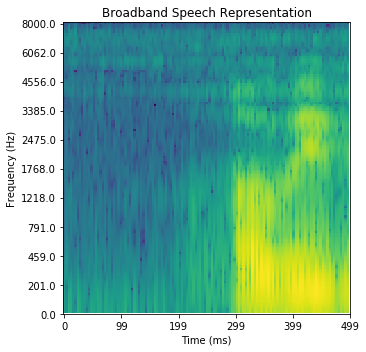

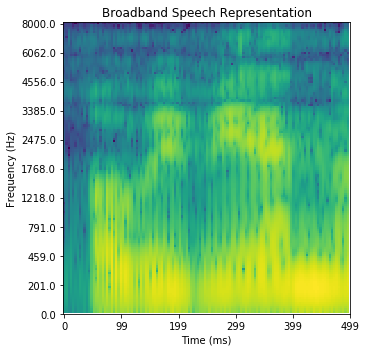

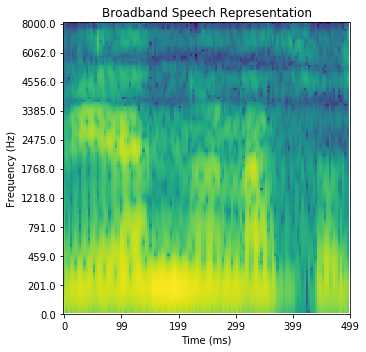

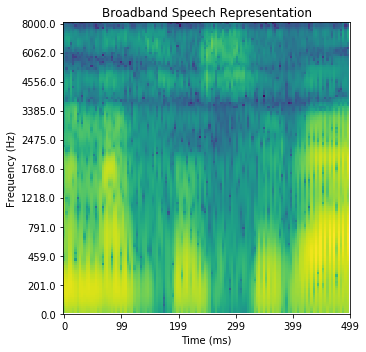

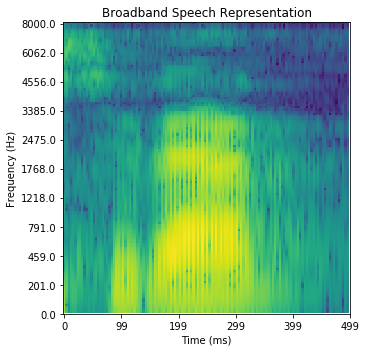

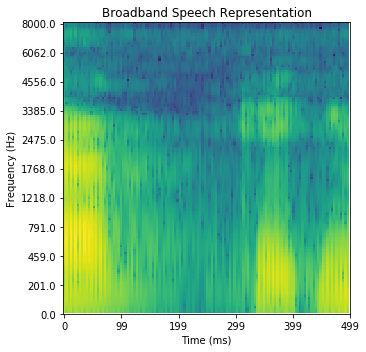

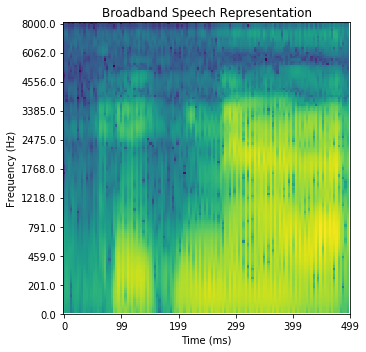

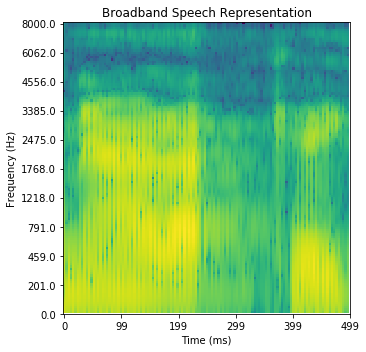

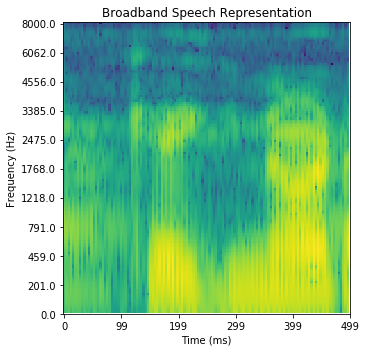

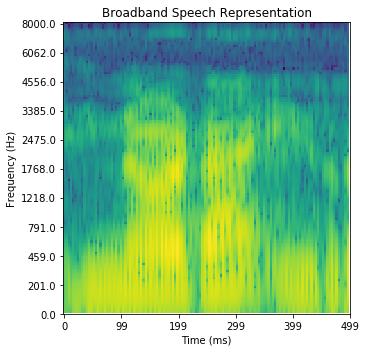

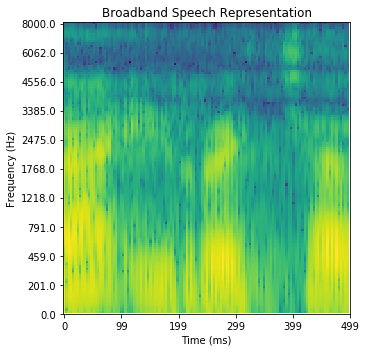

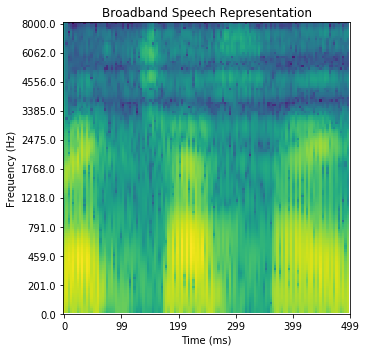

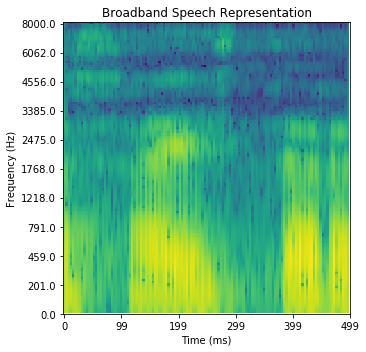

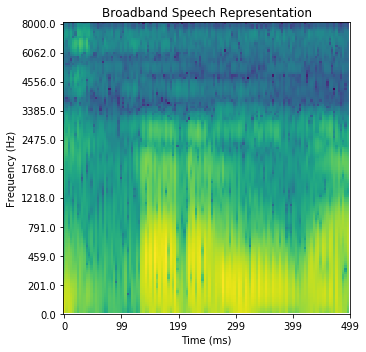

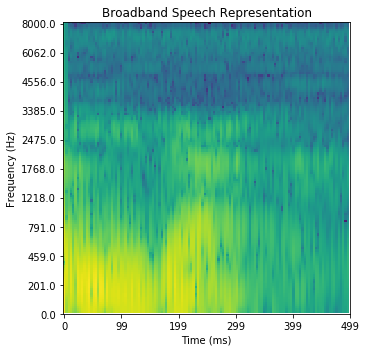

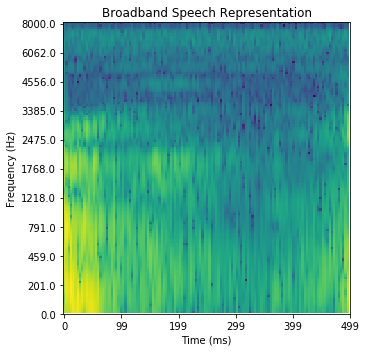

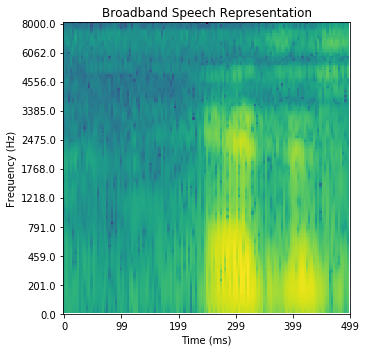

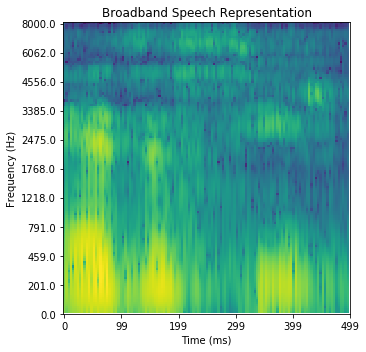

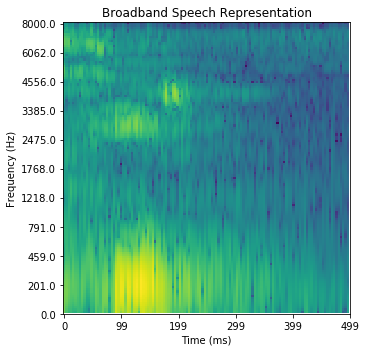

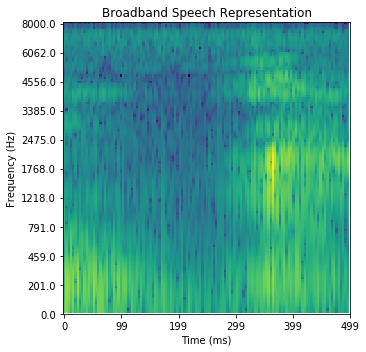

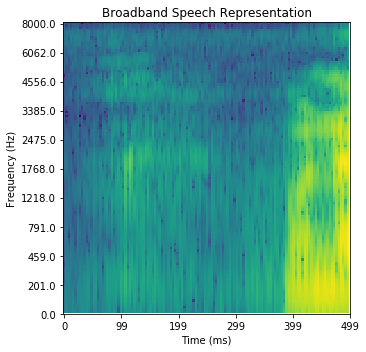

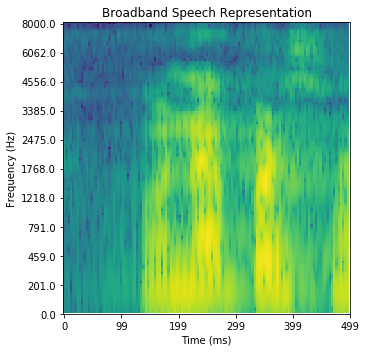

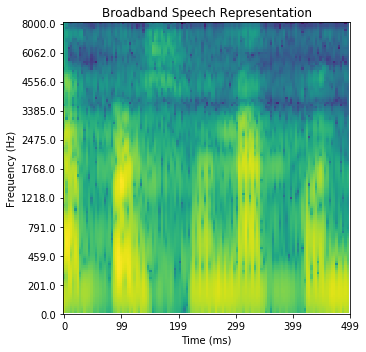

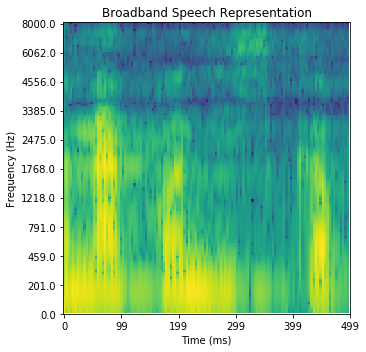

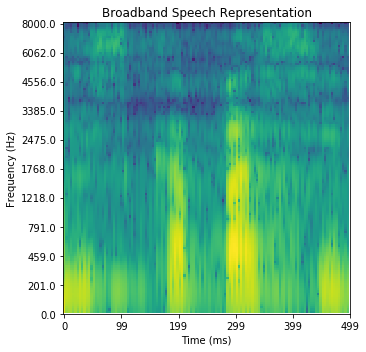

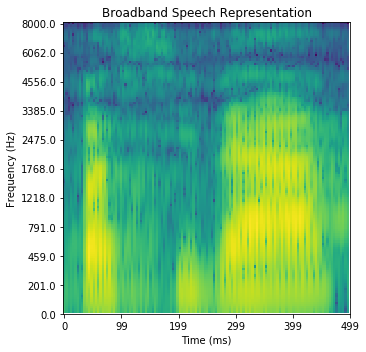

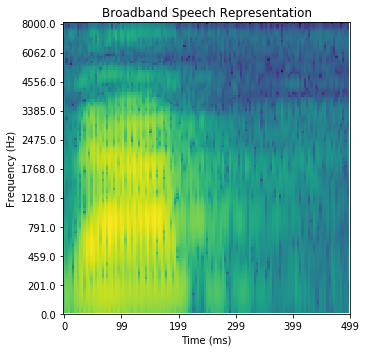

In [6]:

mod='CAE'
unit=256

PATH=os.getcwd()
nb=0
path_audio=PATH+'/tedx_spanish_corpus/speech/train/'
wav_file=path_audio+os.listdir(path_audio)[2]

if nb==1:
    title="Narrowband Speech Representation"
    nmels=128
    rep='narrowband'
else:
    title="Broadband Speech Representation"
    nmels=64
    rep='broadband'
    
    
    
# aespeech=AEspeech(model=mod,units=unit,rep=rep)
# mat,sig_len=aespeech.compute_spectrograms(wav_file,volta=1)
# aespeech.show_spectrograms(sig_len,mat)

mat,sig_len=compute_spectrograms(wav_file,nb,nmels)
show_spectrograms(mat,sig_len,title,nb)

In [ ]:
"""Bicubic Interpolation"""

In [60]:
DIM=(126,128)
interp_spec=cv2.resize(np.real(mat[-3,0,:,:].detach().numpy()),DIM,interpolation=cv2.INTER_CUBIC)
interp_mat=torch.unsqueeze(torch.from_numpy(interp_spec),dim=0)

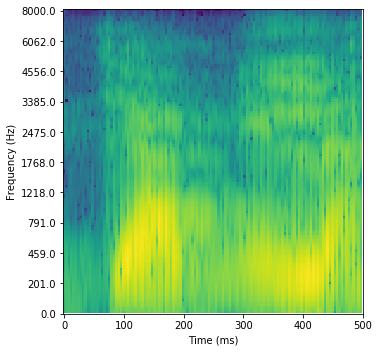

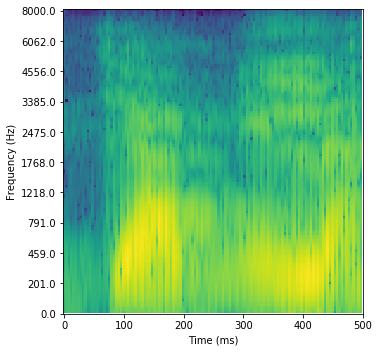

In [65]:
show_spectrograms(torch.unsqueeze(torch.cat((mat[-3,:,:,:],interp_mat),dim=0),dim=1),sig_len,"",nb)

In [ ]:
# PATH=os.getcwd()
# path_audio=PATH+'/tedx_spanish_corpus/speech/train/'
# wav_file=path_audio+os.listdir(path_audio)[2]

# fs,signal=read(wav_file)
# fs_new=16000

# if fs!=16000:
#     raise ValueError(str(fs)+" is not a valid sampling frequency")

# NFR=256
# FRAME_SIZE=int(signal.shape[0]/NFR)
# OVRLP=0.5
# TIME_SHIFT=int(FRAME_SIZE*OVRLP)
# NBF=128

# signal=signal-np.mean(signal)
# signal=signal/np.max(np.abs(signal))

# init=0
# endi=FRAME_SIZE
# [freqs,psi,phi]=create_wavelets(FRAME_SIZE,nbf=NBF,dil=1.25)


# wv_mat=np.zeros((1,NFR,NBF),dtype=np.float32)
# fpsis=np.zeros((NFR,NBF,FRAME_SIZE))
# frames=np.zeros((NFR,FRAME_SIZE))

# for k in range(NFR):
#     frames[k,:]=signal[init:endi]                       
#     init=init+int(TIME_SHIFT)
#     endi=endi+int(TIME_SHIFT)
#     fpsis[k,:,:],fphi=wavelet_transform(frames[k,:],psi,phi)
        
#     fpw=np.mean(fpsis[k,:,:]**2,axis=1)
#     wv_mat[:,k,:]=fpw